Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.033457108..1.0202068].


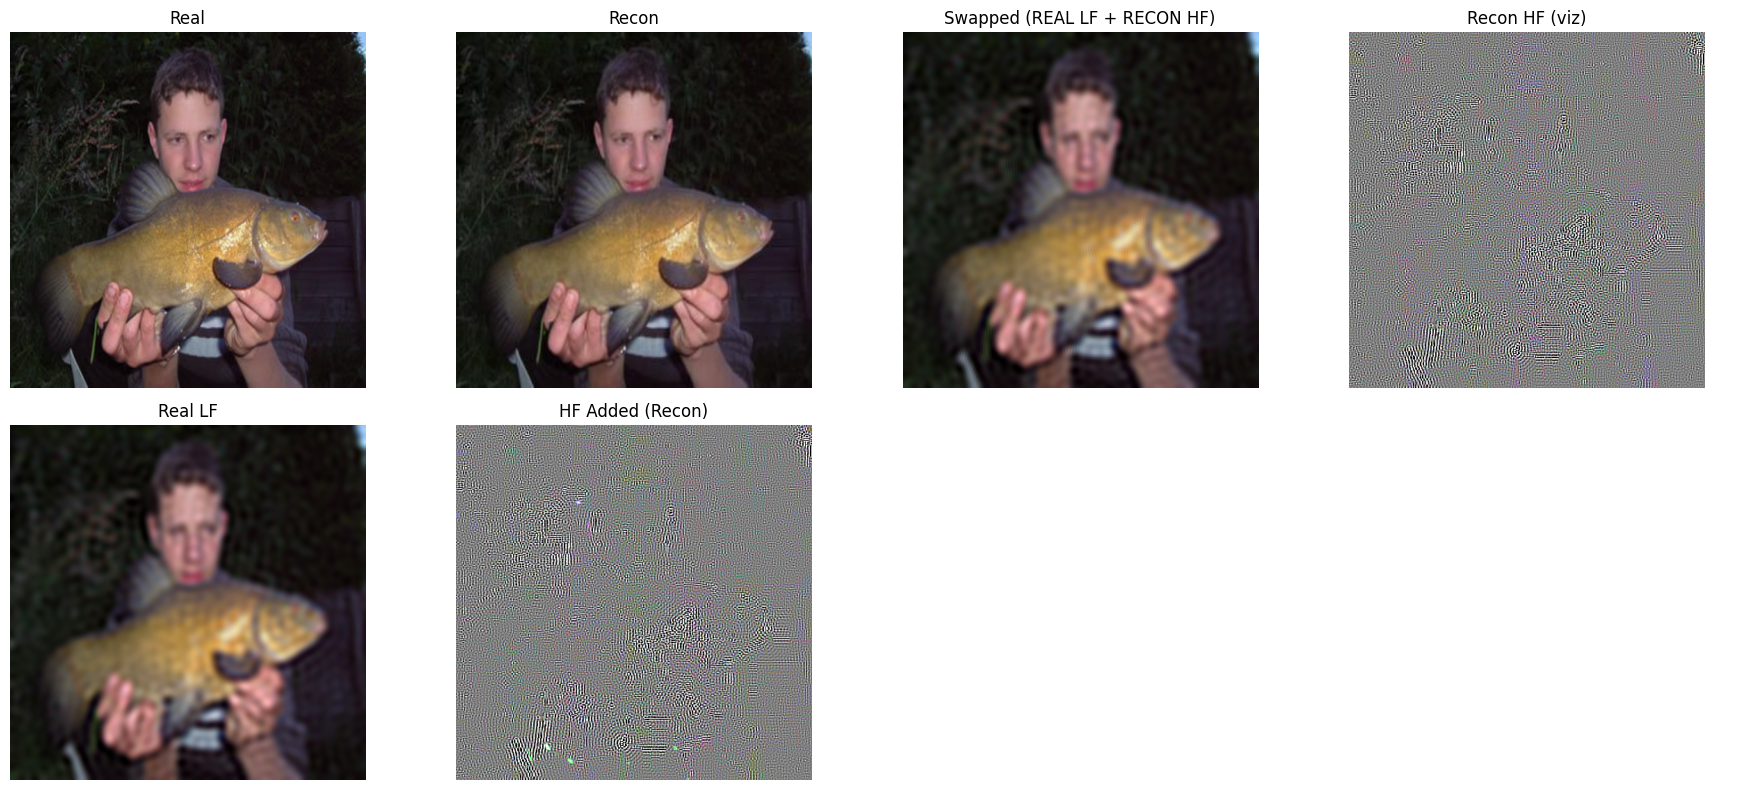

In [3]:
#============================================================
# Single-cell LF/HF Swap (REAL LF + RECON HF) — Corrected
# ============================================================

import torch
import torch_dct as dct
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image

# ----------------------------
# CONFIG
# ----------------------------
REAL_PATH  = r"E:\HFLF\artifact\real.JPEG"
RECON_PATH = r"E:\HFLF\artifact\recon.JPEG"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

LF_CUTOFF = 0.12
HF_CUTOFF = 0.45

# ----------------------------
# DCT helpers (TRUE DCT-II)
# ----------------------------
def apply_dct(x):
    return dct.dct_2d(x, norm="ortho")

def apply_idct(x):
    return dct.idct_2d(x, norm="ortho")

def radial_mask(h, w, cutoff, device):
    yy, xx = torch.meshgrid(
        torch.linspace(0, 1, h, device=device),
        torch.linspace(0, 1, w, device=device),
        indexing="ij"
    )
    r = torch.sqrt(xx**2 + yy**2)
    return (r <= cutoff).float()[None, None, :, :]

# ----------------------------
# Load images
# ----------------------------
transform = T.Compose([
    T.Resize((512, 512)),
    T.ToTensor()
])

real  = transform(Image.open(REAL_PATH).convert("RGB")).unsqueeze(0).to(DEVICE)
recon = transform(Image.open(RECON_PATH).convert("RGB")).unsqueeze(0).to(DEVICE)

# ----------------------------
# DCT
# ----------------------------
real_dct  = apply_dct(real)
recon_dct = apply_dct(recon)

_, _, H, W = real_dct.shape

lf_mask = radial_mask(H, W, LF_CUTOFF, DEVICE)
hf_mask = 1 - radial_mask(H, W, HF_CUTOFF, DEVICE)

# ----------------------------
# Frequency components
# ----------------------------
real_lf  = apply_idct(real_dct * lf_mask)
recon_hf = apply_idct(recon_dct * hf_mask)

# ----------------------------
# CORRECT SWAP
# REAL LF + RECON HF
# ----------------------------
swap_dct = real_dct * lf_mask + recon_dct * hf_mask
swap = apply_idct(swap_dct).clamp(0, 1)

# ----------------------------
# Visualization helpers
# ----------------------------
def viz_zero_mean(x, eps=1e-6):
    m = x.mean(dim=(-2, -1), keepdim=True)
    s = x.std(dim=(-2, -1), keepdim=True)
    x = (x - m) / (s + eps)
    return (0.5 + 0.25 * x).clamp(0, 1)

def show(ax, x, title):
    ax.imshow(x[0].permute(1,2,0).cpu().numpy())
    ax.set_title(title)
    ax.axis("off")

# ----------------------------
# Display
# ----------------------------
fig, ax = plt.subplots(2, 4, figsize=(18, 8))

show(ax[0,0], real,  "Real")
show(ax[0,1], recon, "Recon")
show(ax[0,2], swap,  "Swapped (REAL LF + RECON HF)")
show(ax[0,3], viz_zero_mean(recon_hf), "Recon HF (viz)")

show(ax[1,0], real_lf, "Real LF")
show(ax[1,1], viz_zero_mean(swap - real_lf), "HF Added (Recon)")
ax[1,2].axis("off")
ax[1,3].axis("off")

plt.tight_layout()
plt.show()